In [1]:
from sklearn.preprocessing import StandardScaler
import os
import pandas as pd
from sklearn import datasets
import plotly as plt
import plotly.express as px
from features import *
from clustering import *
from utils import *
from constant import  PATH_OUTPUT, MODEL_CLUSTERING, PATH_DATA, PATH_DATA_ALL

from sklearn.cluster import KMeans

from sklearn.pipeline import Pipeline

from skimage.transform import resize

In [2]:
from images import load_images_from_folder

# Example usage:
folder_path = PATH_DATA_ALL + "/code_test"
images, labels_true, folder_names, smallest_height, smallest_width, smallest_height2, smallest_width2 = load_images_from_folder(folder_path)
taille = len(images)
nombre_de_canaux = 3
# print(f"Smallest height: {smallest_height}")
# print(f"Smallest width: {smallest_width}")
# print(f"Hightest height: {smallest_height2}")
# print(f"Hightest width: {smallest_width2}")

In [3]:

# Supposons que `images` est votre liste d'images en RGB
descriptors_hsv = convert_color_space(images, "HSV") # ou "Lab"

In [4]:
# descriptors_sift = compute_sift_descriptors(images)
sift_descriptors = extract_sift_features(images)
print(f"Taille de sift_descriptors: {len(sift_descriptors)}")
# Étape 2 : Création des vecteurs de caractéristiques avec Bag of Features
descriptors_sift = create_bag_of_features(sift_descriptors, n_clusters=20)

Taille de sift_descriptors: 42


In [5]:

print(f"Taille de sift_descriptors: {len(sift_descriptors[1])}")

Taille de sift_descriptors: 221


In [6]:
images_to_use = descriptors_hsv

In [7]:

descriptors_hog = compute_hog_descriptors(images_to_use)

In [8]:
descriptors_hist = compute_gray_histograms(images_to_use)

In [9]:
print(np.array(descriptors_hog).shape)
print(np.array(descriptors_hsv).shape)
print(np.array(descriptors_sift).shape)

(42, 8192)
(42, 256, 256, 3)
(42, 20)


**3. Application de RBM et KMEANS**

In [10]:
from sklearn.preprocessing import StandardScaler

descriptors = descriptors_hist

# Présumons que `images` est votre liste d'images prétraitées et aplatie en vecteurs

# Initialisation de la classe StackedRBM
stacked_rbm = StackedRBM(n_components_list=[256, 128], n_iter=10, learning_rate=0.01, batch_size=10)

# Ajustement des RBMs sur les données d'image
stacked_rbm.fit(descriptors)

# Transformation des images en nouvelles représentations avec les RBMs entraînés
transformed_images = stacked_rbm.transform(descriptors)

# Normalisation des caractéristiques pour améliorer les performances de K-Means
scaler = StandardScaler()
transformed_images_scaled = scaler.fit_transform(transformed_images)

# Clustering avec K-Means
kmeans = KMeans(n_clusters=20, random_state=42)
clusters = kmeans.fit_predict(transformed_images_scaled)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -11.62, time = 1.35s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -121978.10, time = 0.26s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -3.28, time = 0.38s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -3.36, time = 0.24s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -2.09, time = 0.32s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -1.81, time = 0.37s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -1.12, time = 0.33s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -669382.73, time = 0.18s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -1.40, time = 0.22s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -0.93, time = 0.21s
[BernoulliRBM] Iteration 1, pseudo-likelihood = -185.55, time = 0.07s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -181.04, time = 0.14s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -177.14, time = 0.18s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -175.64, time = 0.32s
[BernoulliRBM] Iteration 5, 

c:\Users\comma\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1474: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (20). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


In [14]:
print(clusters)

[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1
 0 0 0 0 1]


In [11]:
print("\n\n##### Résultat ######")
metric_hist = show_metric(labels_true, clusters, transformed_images_scaled, bool_show=True, name_descriptor="HISTOGRAM", bool_return=True)




##### Résultat ######
########## Métrique descripteur : HISTOGRAM
Adjusted Mutual Information: -0.00973927291987954
Silhouette Score: 1.0


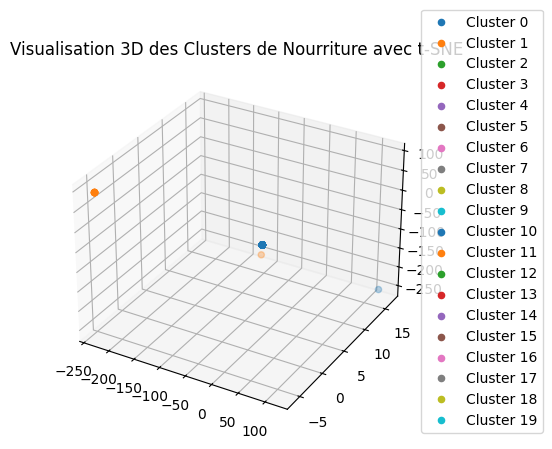

In [12]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as pylt


# Réduction de dimensionnalité avec t-SNE
tsne = TSNE(n_components=3, random_state=42)  # Utilisez n_components=2 pour une visualisation 2D
tsne_results = tsne.fit_transform(transformed_images_scaled)

# Visualisation 3D avec t-SNE
fig = pylt.figure()
# fig = pylt.figure(figsize=(10, 8), dpi=100) 
ax = fig.add_subplot(111, projection='3d')

for i in range(20):
    ax.scatter(tsne_results[clusters == i, 0], tsne_results[clusters == i, 1], tsne_results[clusters == i, 2], label=f'Cluster {i}')

ax.set_title('Visualisation 3D des Clusters de Nourriture avec t-SNE')
# pylt.legend()
# pylt.legend(loc='upper left', bbox_to_anchor=(1,1))
pylt.legend(loc=(1, 0))
pylt.show()


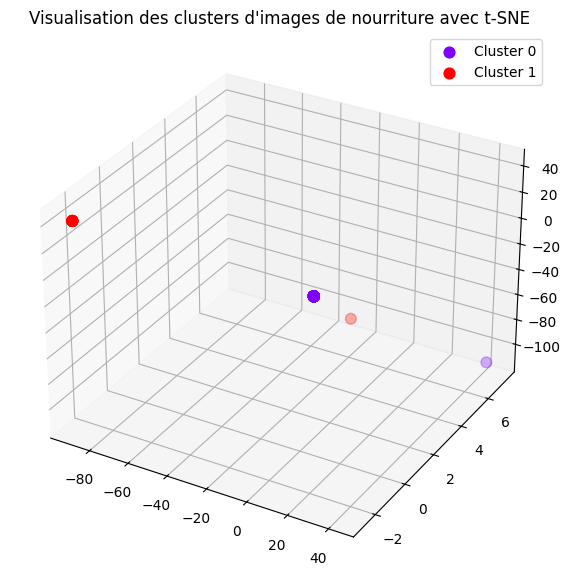

In [13]:
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

# Réduction de dimension avec t-SNE
tsne = TSNE(n_components=3, perplexity=30.0, n_iter=300, random_state=42)
transformed_images_tsne = tsne.fit_transform(transformed_images_scaled)

# Création d'un graphique 3D pour visualiser les clusters
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Colorier chaque cluster
colors = plt.cm.rainbow(np.linspace(0, 1, len(set(clusters))))
for i in range(len(set(clusters))):
    ax.scatter(transformed_images_tsne[clusters == i, 0], 
               transformed_images_tsne[clusters == i, 1], 
               transformed_images_tsne[clusters == i, 2], 
               color=colors[i], 
               label='Cluster ' + str(i), 
               s=60)

ax.legend()
ax.grid(True)
plt.title('Visualisation des clusters d\'images de nourriture avec t-SNE')
plt.show()
